In [68]:
import sys 
sys.path.append('../')
import_path = '../export/'

In [69]:
import pandas as pd
from sklearn.cluster import DBSCAN, AffinityPropagation, KMeans
import seaborn as sns
def models(): 
    return {
        'KMeans': KMeans(n_clusters=4, init='random', algorithm='lloyd'),
        'AffinityPropagation': AffinityPropagation(damping=0.5, affinity='euclidean'),
        'DBSCAN': DBSCAN(min_samples=4, metric='euclidean')
    }
def compare_datasets(dataset1, dataset2, epsilon):
    sns.scatterplot(data=dataset1, x='X', y='Y', label='baseline')
    sns.scatterplot(data=dataset2, x='X', y='Y', label='epsilon: {eps}'.format(eps=epsilon))
def load_dataset(datasetname):
    df = pd.read_csv(datasetname)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df
def load_plain_and_perturbed_dataset(epsilon):
    dataset_name1 = import_path + 'plain.csv'
    dataset_name2 = import_path + 'perturbed_' + str(epsilon) + '.csv'
    dataset1 = load_dataset(dataset_name1)
    dataset2 = load_dataset(dataset_name2)
    return dataset1, dataset2

def load_and_compare(epsilon):
    dataset1, dataset2 = load_plain_and_perturbed_dataset(epsilon)
    compare_datasets(dataset1, dataset2, epsilon)

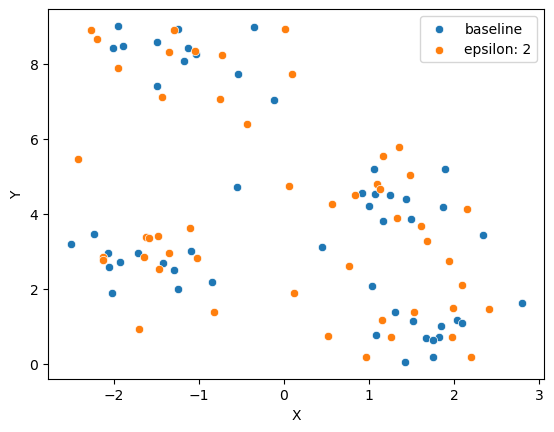

In [70]:
load_and_compare(2)

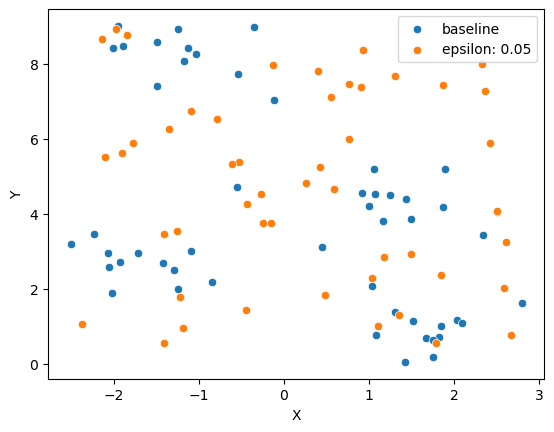

In [71]:
load_and_compare(0.05)

## Clustering

In [72]:
import numpy as np
from sklearn import clone
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score, silhouette_score

supported_epsilons = [0.05, 0.5, 1, 2, 3, 6]
export_path = import_path + 'utility_scores'

def measure_external_validity_report(epsilon, cluster_model):
    plain_df, perturbed_df = load_plain_and_perturbed_dataset(epsilon)
    plain_df_scaled = StandardScaler().fit_transform(plain_df)
    perturbed_df_scaled = StandardScaler().fit_transform(perturbed_df)
    plain_fitted_df = cluster_model.fit(plain_df_scaled)
    perturbed_fitted_df = clone(cluster_model).fit(perturbed_df_scaled)
    ami = adjusted_mutual_info_score(plain_fitted_df.labels_, perturbed_fitted_df.labels_)
    ari = adjusted_rand_score(plain_fitted_df.labels_, perturbed_fitted_df.labels_)
    ch = calinski_harabasz_score(perturbed_df_scaled, perturbed_fitted_df.labels_)
    sc = silhouette_score(perturbed_df_scaled, perturbed_fitted_df.labels_)
    return ami, ari, ch, sc
    
def generate_external_validity_export(epsilons, models, n_times = 10):
    dataframe = {'type': [], 'epsilon': [], 'ari': [], 'ami': [], 'ch': [], 'sc': []}
    for epsilon in epsilons:
        for model in models:
            algorithmName = type(model).__name__
            dataframe['type'].append(algorithmName)
            dataframe['epsilon'].append(epsilon)
            ami_list = []
            ari_list = []
            ch_list = []
            sc_list = []
            for i in range(n_times):
                ami, ari, ch, sc = measure_external_validity_report(epsilon, model)
                ami_list.append(ami)
                ari_list.append(ari)
                ch_list.append(ch)
                sc_list.append(sc)
            ami = np.sum(ami_list) / n_times
            ari = np.sum(ari_list) / n_times
            sc = np.sum(sc_list) / n_times
            dataframe['ami'].append(ami)
            dataframe['ari'].append(ari)
            dataframe['ch'].append(np.sum(ch_list) / n_times)
            dataframe['sc'].append(np.sum(sc_list) / n_times)

    pd.DataFrame(dataframe).to_csv(export_path + '/report.csv')

In [73]:
supported_models = list(models().values())
print(supported_models)

[KMeans(init='random', n_clusters=4), AffinityPropagation(), DBSCAN(min_samples=4)]


In [74]:
generate_external_validity_export(supported_epsilons, supported_models)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff543ba550>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff543ba550>
Traceback 

## Report

In [75]:
utility_metrics = load_dataset(export_path + '/report.csv')
utility_metrics.head()

,type,epsilon,ari,ami,ch,sc
0,KMeans,0.05,-0.018123,-0.025752,50.366100,0.439026
1,AffinityPropagation,0.05,0.026348,0.034362,55.934586,0.489304
2,DBSCAN,0.05,0.026836,0.006443,13.966512,0.283707
3,KMeans,0.50,0.091332,0.122014,52.951326,0.406272
4,AffinityPropagation,0.50,0.109568,0.131834,56.256721,0.408800


In [76]:
from matplotlib import pyplot as plt

def plot_utility(dataframe, epsilons, metric_name, axes, metric = 'Adjusted Mutual Information (AMI)', title='External validation: Evaluating private clusters algorithms, against ground truth non-private cluster algorithms'): 
    ax = sns.lineplot(x='epsilon', y=metric_name, data=dataframe, ax=axes, style='type', hue='type', markers=True, legend=True)
    ax.set_xticks(epsilons, labels=epsilons)
    ax.set_title(title)
    ax.set_xlabel('Privacy budget ($\epsilon$)')
    ax.set_ylabel(metric)
    plt.legend(title='Cluster algorithm', loc='upper left', labels=dataframe['type'].unique())

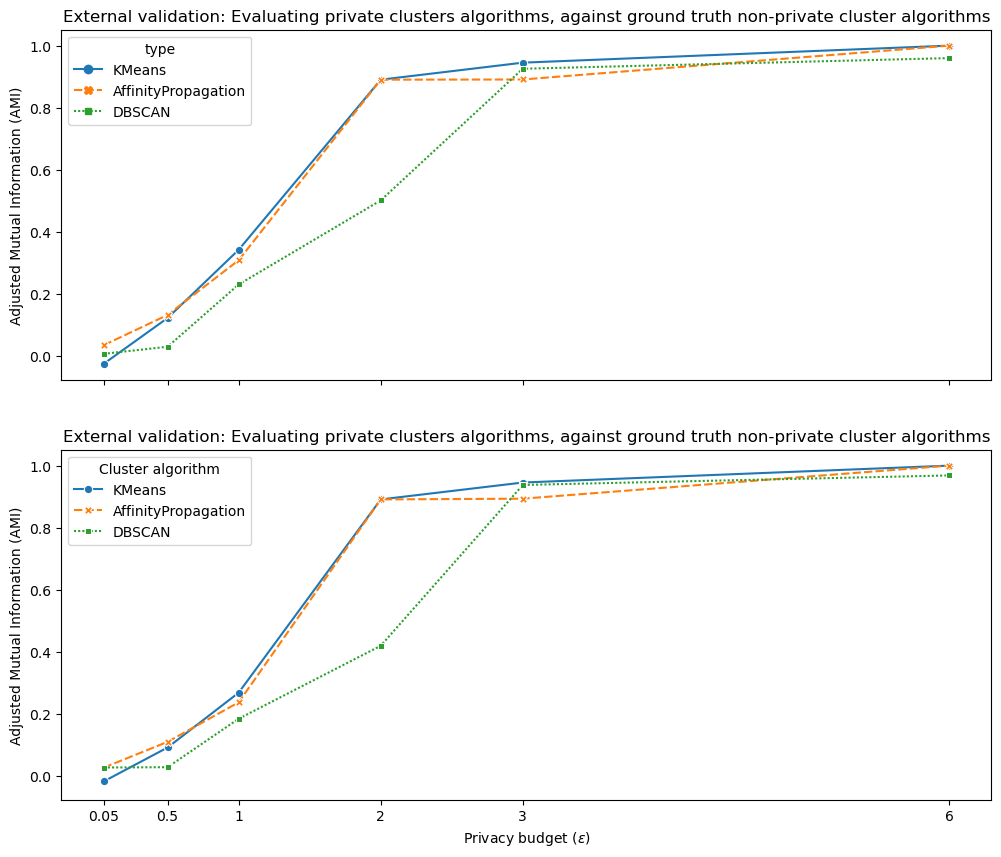

In [77]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(12, 10))
plot_utility(utility_metrics, supported_epsilons, 'ami', axes=axs[0])
plot_utility(utility_metrics, supported_epsilons, 'ari', axes=axs[1])

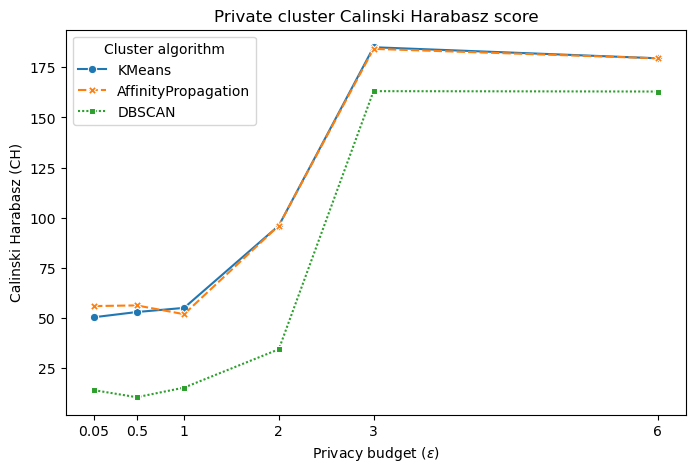

In [78]:
fig, axs = plt.subplots(figsize=(8, 5))

plot_utility(utility_metrics, supported_epsilons, 'ch', axes=axs, metric='Calinski Harabasz (CH)', title='Private cluster Calinski Harabasz score')

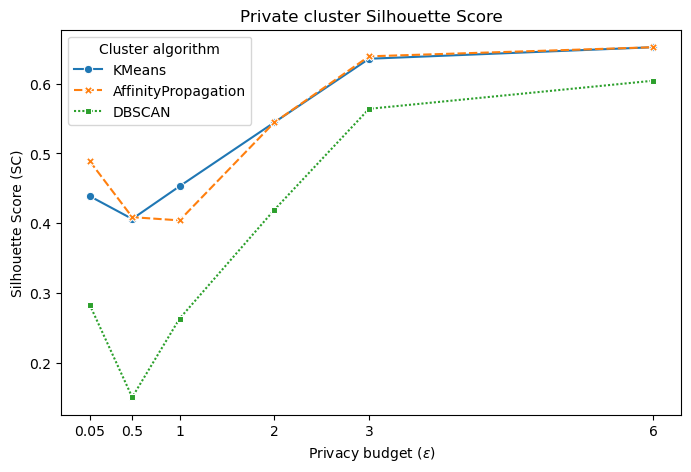

In [79]:
fig, axs = plt.subplots(figsize=(8, 5))

plot_utility(utility_metrics, supported_epsilons, 'sc', axes=axs, metric='Silhouette Score (SC)', title='Private cluster Silhouette Score')